In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

This datasets have multiple readings for the same timestamp values because k6 exports them in seconds.

In [20]:
df = pd.read_csv('datasets/063025-vus10-5min-t3.medium-batch-default.gz')

In [21]:
df_rd = df[df['metric_name'] == 'http_req_duration']

In [50]:
Q1 = df_rd['metric_value'].quantile(0.25)
Q3 = df_rd['metric_value'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_rd = df_rd[(df_rd['metric_value'] >= lower_bound) & (df_rd['metric_value'] <= upper_bound)]

In [22]:
df_rd['timestamp'] = pd.to_datetime(df_rd['timestamp'], unit='s')

/tmp/ipykernel_8627/1986301022.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rd['timestamp'] = pd.to_datetime(df_rd['timestamp'], unit='s')


In [15]:
df_rd_grouped = df_rd.groupby('timestamp').agg({'metric_value': 'mean'}).reset_index()

In [16]:
df_rd_grouped.head()

,timestamp,metric_value
0,2025-07-01 01:13:45,254.518020
1,2025-07-01 01:13:46,192.162080
2,2025-07-01 01:13:47,244.770873
3,2025-07-01 01:13:48,229.587037
4,2025-07-01 01:13:49,259.649317


In [17]:
df_rd_grouped = df_rd_grouped.dropna(subset=['metric_value'])

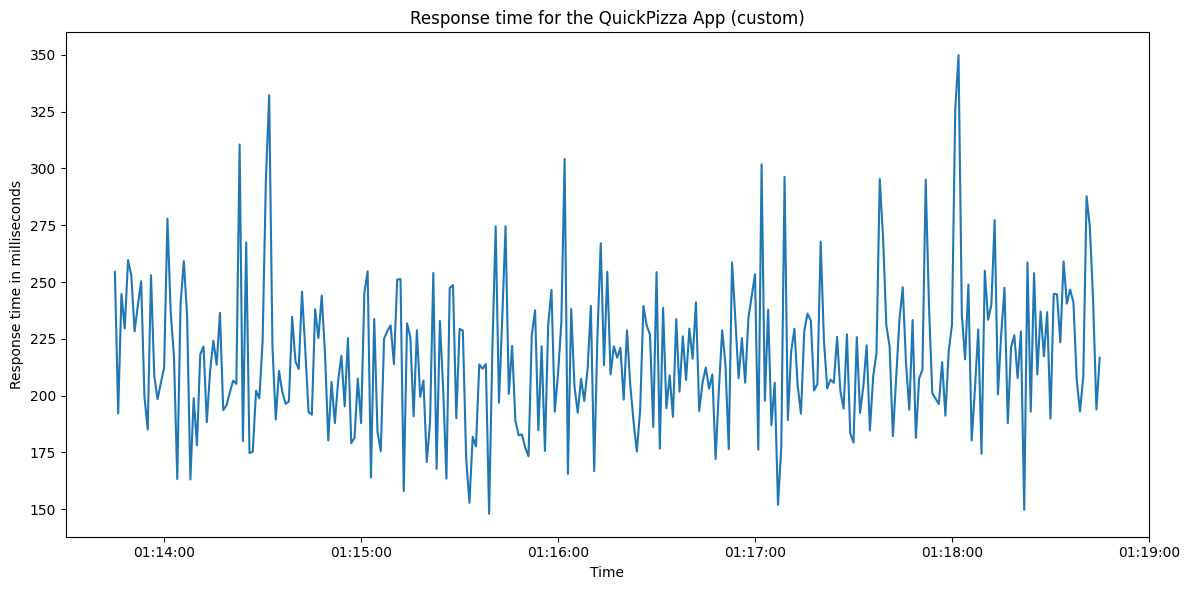

In [20]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=df_rd_grouped, x='timestamp', y='metric_value')

plt.title('Response time for the QuickPizza App (custom)')

plt.xlabel('Time')
plt.ylabel('Response time in milliseconds')

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()

In [77]:
df_mean = df_rd.groupby('timestamp').agg({ 'metric_value': 'mean' })
df_p95 = df_rd['metric_value'].quantile(0.95)
df_p99 = df_rd['metric_value'].quantile(0.99)

In [59]:
df_p95

np.float64(449.1751352)

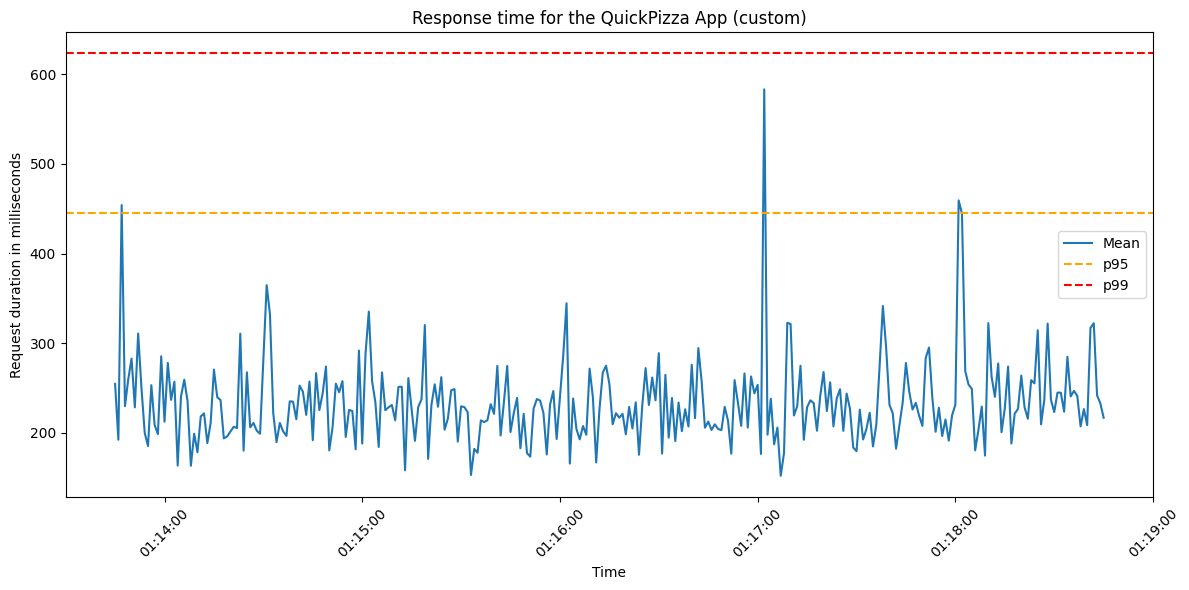

In [79]:
plt.figure(figsize=(12, 6))
ax = plt.gca()

sns.lineplot(data=df_mean, x='timestamp', y='metric_value', label='Mean', ax=ax)

plt.axhline(df_p95, color='orange', linestyle='--', label='p95')
plt.axhline(df_p99, color='red', linestyle='--', label='p99')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xticks(rotation=45)
plt.title('Response time for the QuickPizza App (custom)')
plt.xlabel('Time')
plt.ylabel('Request duration in milliseconds')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
df_requests_per_second = df_rd.groupby('timestamp').agg({ 'metric_value': 'size' })

In [24]:
df_requests_per_second.head()

,metric_value
timestamp,
2025-07-01 01:05:54,9
2025-07-01 01:05:55,3
2025-07-01 01:05:56,8
2025-07-01 01:05:57,10
2025-07-01 01:05:58,10


In [19]:
# Smoothen the data
df_requests_per_second['smooth'] = df_requests_per_second['metric_value'].rolling(window=30, center=True).mean()

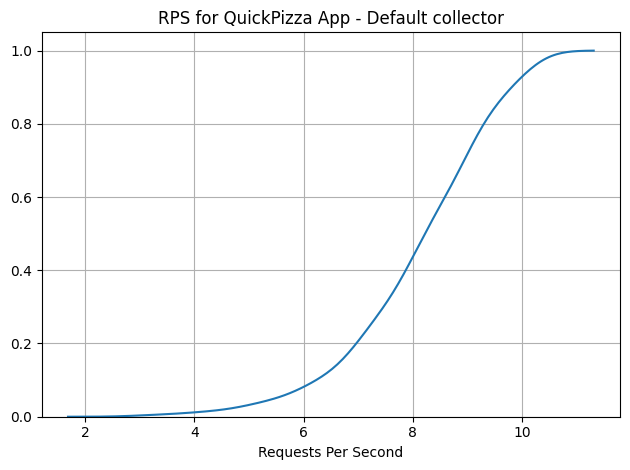

In [25]:
sns.kdeplot(df_requests_per_second['metric_value'], cumulative=True, bw_adjust=1)
plt.xlabel('Requests Per Second')
plt.ylabel('')
plt.title('RPS for QuickPizza App - Default collector')
plt.grid(True)
plt.tight_layout()
plt.show()